<a href="https://colab.research.google.com/github/dlckdtn62/BIO-PREDICTION/blob/master/bio_lgbm_rho_ratio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgbm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lightgbm as lgbm
import xgboost as xgb                       # XGBoost 패키지
from sklearn.model_selection import KFold   # K-Fold CV"

import warnings
warnings.filterwarnings(action='ignore') 
from keras.optimizers import SGD, Adam
from keras import metrics 
from keras.layers import ELU, ELU
from keras.models import Sequential
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from lightgbm import LGBMRegressor,  plot_importance
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression

import tensorflow as tf
import keras
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
print('pandas         {}'.format(pd.__version__))
print('numpy          {}'.format(np.__version__))
# print('matplotlib     {}'.format(matplotlib.__version__))
print('seaborn        {}'.format(sns.__version__))
# print('xgboost        {}'.format(xgb.__version__))
# print('sklearn        {}'.format(sklearn.__version__))

pandas         1.0.4
numpy          1.18.4
seaborn        0.10.1


In [0]:
path = "/content/drive/My Drive/dacon/bio/"

In [0]:
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
sample_submission = pd.read_csv(path+'sample_submission.csv')

In [5]:
"""
id : 구분자
rho : 측정 거리 (단위: mm)
src : 광원 스펙트럼 (650 nm ~ 990 nm)
dst : 측정 스펙트럼 (650 nm ~ 990 nm)
hhb : 디옥시헤모글로빈 농도
hbo2 : 옥시헤모글로빈 농도
ca : 칼슘 농도
na : 나트륨 농도
"""

'\nid : 구분자\nrho : 측정 거리 (단위: mm)\nsrc : 광원 스펙트럼 (650 nm ~ 990 nm)\ndst : 측정 스펙트럼 (650 nm ~ 990 nm)\nhhb : 디옥시헤모글로빈 농도\nhbo2 : 옥시헤모글로빈 농도\nca : 칼슘 농도\nna : 나트륨 농도\n'

In [6]:
total = pd.concat([train.iloc[:,:-4],test],axis=0, ignore_index=True)
# scaler = StandardScaler()
# # total.loc[:,'650_src':'990_src'] = scaler.fit_transform(total.loc[:,'650_src':'990_src'])
# # total.loc[:,'650_dst':'990_dst'] = scaler.fit_transform(total.loc[:,'650_dst':'990_dst'])
# total.loc[:,'650_src':'990_dst'] = scaler.fit_transform(total.loc[:,'650_src':'990_dst'])
total.drop(['id'], axis=1, inplace=True, errors='ignore')
total.head()

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,6.412913e-18,1.098559e-17,8.907142e-19,NaN,0.000000e+00,NaN,0.000000e+00,5.901745e-18,NaN,1.176812e-18,NaN,5.557492e-17,1.046498e-16,NaN,7.236748e-17,4.021610e-17,2.397489e-17,1.870153e-17,1.808920e-17,NaN,0.000000e+00,2.626216e-18,NaN,3.527371e-18,NaN,6.455564e-19,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17
1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,1.025259e-10,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,1.151021e-10,4.318673e-10,2.753933e-10,0.000000e+00,8.138830e-10,6.522110e-10,NaN,2.732232e-10,NaN,7.663267e-11,NaN,1.389496e-10,1.472282e-09,1.450463e-09,1.225321e-09,2.647633e-09,NaN,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN
2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,0.000000e+00,NaN,NaN,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,3.349335e-19,NaN,0.000000e+00,2.630961e-18,NaN,0.000000e+00,9.912979e-18,1.112747e-17,NaN,NaN,NaN,1.260239e-19,NaN,0.000000e+00,3.876159e-18,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN
3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,NaN,1.583839e-10,NaN,1.678049e-10,2.814419e-10,4.429321e-10,1.319956e-09,2.269806e-09,2.679164e-09,2.538200e-09,2.046841e-09,1.516820e-09,1.328007e-09,1.061359e-09,8.634016e-10,5.804951e-10,3.615067e-10,NaN,1.274876e-10,6.118947e-11,NaN,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN
4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98861,0.98270,1.00432,1.01434,1.01455,0.98861,0.98300,1.00616,0.99045,1.01321,1.01559,1.01072,0.99439,0.98597,0.99889,1.01412,4.784751e-14,NaN,0.000000e+00,1.153089e-13,0.000000e+00,0.000000e+00,1.056991e-13,0.000000e+00,0.000000e+00,2.666663e-14,1.493071e-14,NaN,0.000000e+00,1.200730e-13,2.648249e-13,NaN,4.392331e-13,2.831191e-13,4.557059e-13,1.326038e-13,1.864796e-13,1.419359e-13,1.765559e-13,1.593789e-13,NaN,0.000000e+00,NaN,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN


In [0]:
total.head()
total_dst = total.filter(regex='dst$|rho')
total_dst

dst_cols = total_dst.columns[1:]
dst_cols

dst_dic = {}
for i, col in enumerate(dst_cols):
    dst_dic[col] = i

In [0]:
dst_cols_sorted = total_dst.isnull().sum().sort_values().index[1:]

In [0]:
# plt.figure(figsize=(15,15))
# corrs = total_dst[dst_cols].corr()
# sns.heatmap(corrs, annot=True, square=True)

In [0]:
# total[dst_cols].T.iloc[:,10000:20000].plot(figsize=(20,10), legend=False)

In [11]:
total.isnull().sum().sum()

140168

In [0]:
total_inpterpolate = total.T.interpolate(method='linear')[::-1].interpolate(method='linear')[::-1].T

NAN채워봅시

In [0]:
total_ = total.copy()
dst = total_.filter(regex='dst')
dst_cols = dst.columns

In [0]:
# NaN이 한칸만 있는 경우 양옆 칸의 평균으로 채움
dst = dst.fillna(-1)

def fill_nan_mid(row):
    for i in range(len(row)):
        if row[i] < 0:
            try:
                if (row[i-1] >= 0) & (row[i+1] >= 0):
                    row[i] = (row[i-1]+row[i+1])/2
            except:
                pass
    return row

for i in dst.index:
    dst.loc[i,:] = fill_nan_mid(dst.loc[i,:])

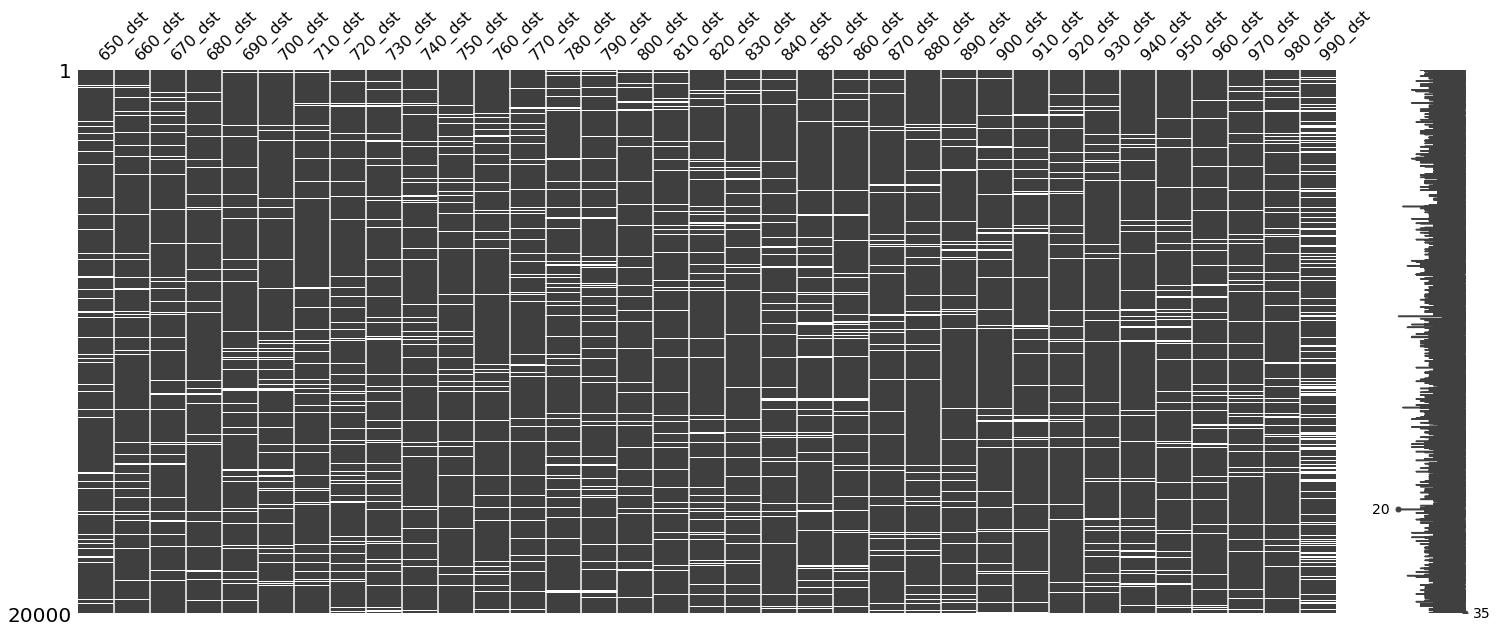

In [16]:
import missingno as msno

msno.matrix(dst.replace(-1, np.NaN))

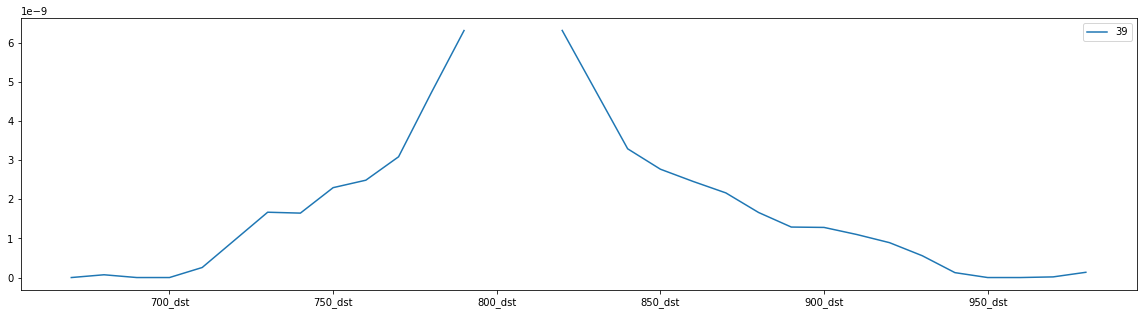

In [17]:
a = 39
b = 40
dst.replace(-1,np.NaN).T.iloc[:,a:b].plot(figsize=(20,5), legend=True)
plt.show()

In [0]:
# dst_container = dst.copy()

In [0]:
# dst = dst_container.copy()

In [0]:
linear = LinearRegression()


def fill_nan_from_left2(row):
    for i in range(2,len(row)):
        if row[i] == -1:
            if (row[i-1] != -1) & (row[i-2] != -1):
                yTrn = row[i-2:i]
                xTrn = np.arange(1,3).reshape(-1,1)
                xTst = np.arange(1,4).reshape(-1,1)

                pred = linear.fit(xTrn, yTrn).predict(xTst)
                row[i] = pred[-1] if pred[-1] >= 0 else 0
                break
    return row

def fill_nan_from_right2(row):
    for i in range(len(row)-3, -1, -1):
        if row[i] == -1:
            if (row[i+1] != -1) & (row[i+2] != -1):
                yTrn = row[i+1:i+3]
                xTrn = np.arange(2,4).reshape(-1,1)
                xTst = np.arange(1,4).reshape(-1,1)

                pred = linear.fit(xTrn, yTrn).predict(xTst)
                row[i] = pred[0] if pred[0] >= 0 else 0
                break
    return row

In [21]:
for i in dst.index:
    print(i)
    while (dst.loc[i,:] < 0).sum() != 0:
        dst.loc[i,:] = fill_nan_from_left2(dst.loc[i,:])
        dst.loc[i,:] = fill_nan_from_right2(dst.loc[i,:])
        dst.loc[i,:] = fill_nan_mid(dst.loc[i,:])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
15001
15002
15003
15004
15005
15006
15007
15008
15009
15010
15011
15012
15013
15014
15015
15016
15017
15018
15019
15020
15021
15022
15023
15024
15025
15026
15027
15028
15029
15030
15031
15032
15033
15034
15035
15036
15037
15038
15039
15040
15041
15042
15043
15044
15045
15046
15047
15048
15049
15050
15051
15052
15053
15054
15055
15056
15057
15058
15059
15060
15061
15062
15063
15064
15065
15066
15067
15068
15069
15070
15071
15072
15073
15074
15075
15076
15077
15078
15079
15080
15081
15082
15083
15084
15085
15086
15087
15088
15089
15090
15091
15092
15093
15094
15095
15096
15097
15098
15099
15100
15101
15102
15103
15104
15105
15106
15107
15108
15109
15110
15111
15112
15113
15114
15115
15116
15117
15118
15119
15120
15121
15122
15123
15124
15125
15126
15127
15128
15129
15130
15131
15132
15133
15134
15135
15136
15137
15138
15139
15140
15141
15142
15143
15144
15145
15146
15147
15148
15149
15150
15151
15152
15153
15154
15155
15156
15157
15158
15159
15160
1516

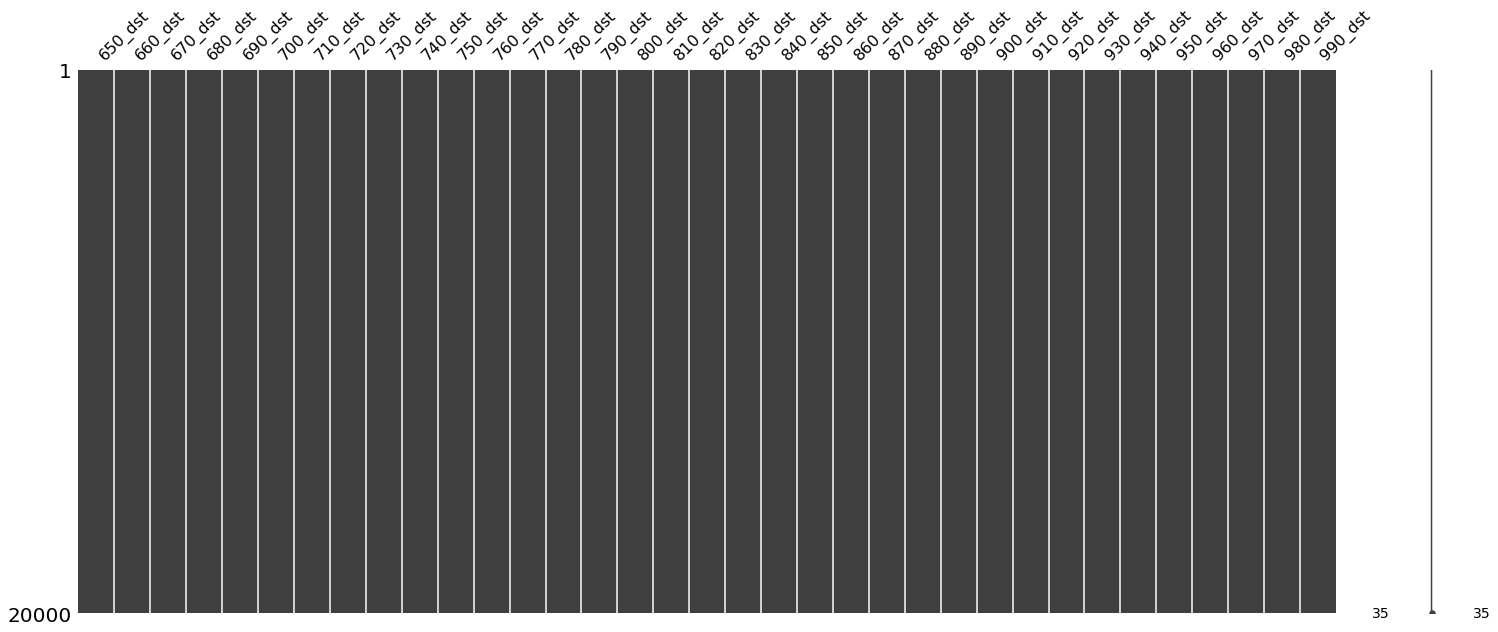

In [22]:
msno.matrix(dst.replace(-1,np.NaN))

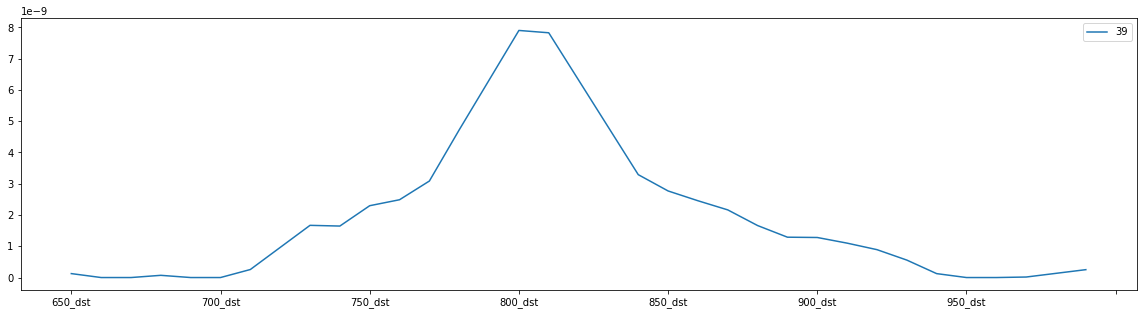

In [23]:
a = 39
b = 40
dst.replace(-1,np.NaN).T.iloc[:,a:b].plot(figsize=(20,5), legend=True)
plt.show()

In [24]:
(dst < 0).sum().sum()

0

In [25]:
dst

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,2.447758e-18,1.894578e-18,0.000000e+00,6.412913e-18,1.098559e-17,8.907142e-19,4.453571e-19,0.000000e+00,0.000000e+00,0.000000e+00,5.901745e-18,3.539278e-18,1.176812e-18,2.837586e-17,5.557492e-17,1.046498e-16,8.850865e-17,7.236748e-17,4.021610e-17,2.397489e-17,1.870153e-17,1.808920e-17,9.044602e-18,0.000000e+00,2.626216e-18,3.076794e-18,3.527371e-18,2.086464e-18,6.455564e-19,3.227782e-19,0.000000e+00,5.337522e-19,1.067504e-18,5.998949e-18,4.378513e-17
1,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,1.025259e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.151021e-10,4.318673e-10,2.753933e-10,0.000000e+00,8.138830e-10,6.522110e-10,4.627171e-10,2.732232e-10,1.749279e-10,7.663267e-11,1.077911e-10,1.389496e-10,1.472282e-09,1.450463e-09,1.225321e-09,2.647633e-09,3.940557e-09,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,5.920319e-09,9.710091e-09,1.349986e-08
2,1.677445e-19,3.763590e-20,1.881795e-20,0.000000e+00,0.000000e+00,4.490826e-19,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,3.349335e-19,1.674668e-19,0.000000e+00,2.630961e-18,1.315480e-18,0.000000e+00,9.912979e-18,1.112747e-17,1.234196e-17,2.520478e-19,1.890358e-19,1.260239e-19,6.301194e-20,0.000000e+00,3.876159e-18,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,2.659450e-18
3,4.044975e-11,4.695169e-11,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,7.958742e-11,1.583839e-10,1.630944e-10,1.678049e-10,2.814419e-10,4.429321e-10,1.319956e-09,2.269806e-09,2.679164e-09,2.538200e-09,2.046841e-09,1.516820e-09,1.328007e-09,1.061359e-09,8.634016e-10,5.804951e-10,3.615067e-10,2.444971e-10,1.274876e-10,6.118947e-11,1.137891e-10,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,2.433592e-10,4.088921e-10,5.744250e-10
4,4.784751e-14,2.392375e-14,0.000000e+00,1.153089e-13,0.000000e+00,0.000000e+00,1.056991e-13,0.000000e+00,0.000000e+00,2.666663e-14,1.493071e-14,7.465355e-15,0.000000e+00,1.200730e-13,2.648249e-13,3.520290e-13,4.392331e-13,2.831191e-13,4.557059e-13,1.326038e-13,1.864796e-13,1.419359e-13,1.765559e-13,1.593789e-13,7.968945e-14,0.000000e+00,7.688095e-15,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,1.103571e-13,1.330237e-13,1.556903e-13,1.783569e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.000000e+00,1.059879e-13,2.119758e-13,3.179636e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.775412e-14,5.283407e-13,1.361983e-12,2.916243e-12,3.104179e-12,3.292114e-12,2.630171e-12,2.554917e-12,2.633107e-12,3.173367e-12,3.178538e-12,1.462668e-12,2.786613e-13,7.889599e-13,6.396404e-13,4.903209e-13,1.365078e-12,7.929664e-13,0.000000e+00,0.000000e+00,1.472213e-13,1.479745e-12,5.391520e-12
19996,0.000000e+00,0.000000e+00,5.283427e-19,3.519532e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.359929e-18,2.179965e-18,0.000000e+00,0.000000e+00,0.000000e+00,1.372321e-17,6.978022e-18,2.328368e-19,2.321802e-17,1.495695e-17,1.998833e-17,2.541768e-17,1.638928e-17,0.000000e+00,1.177027e-18,2.354055e-18,7.622563e-18,1.240848e-17,6.258180e-18,8.693704e-20,2.300693e-18,4.514449e-18,2.713640e-18,9.128300e-19,2.420572e-18,3.928314e-18,2.586781e-17
19997,1.452606e-15,4.033172e-15,2.832304e-15,0.000000e+00,0.000000e+00,0.000000e+00,3.998263e-13,2.593115e-13,1.187968e-13,0.000000e+00,1.287864e-15,2.575729e-15,8.142446e-15,1.336438e-13,2.591451e-13,2.291236e-13,2.978639e-14,0.000000e+00,8.139881e-14,7.438326e-14,6.736772e-14,0.000000e+00,1.205356e-15,4.468513e-15,2.263188e-15,0.000000e+00,0.000000e+00,0.000000e+0

In [0]:
total
train.update(dst.iloc[:10000,:])
test.update(dst.iloc[10000:,:].reset_index(drop=True))

In [0]:
total
train.update(total_inpterpolate.iloc[:10000,:])
test.update(total_inpterpolate.iloc[10000:,:].reset_index(drop=True))


# MODEL

In [0]:
trainTransform = train.copy()
testTransform = test.copy()

진공의 투자율과 상대 투자율
진공의 투자율은 통상적으로 {\displaystyle \mu _{0}}\mu_0라고 적는다. 그 값은 국제단위계를 정의할 때 쓰이므로, 그 정확한 값이 국제단위계로는 정의돼 있는데, 다음과 같다.

μ₀ = 4π×10¯⁷ H/m ≈ 1.2566370614359 μH/m.
매질의 투자율과 진공 투자율의 비는 상대 투자율(相對透磁率, relative permeability)

{\displaystyle \mu _{\text{r}}=\mu /\mu _{0}}{\displaystyle \mu _{\text{r}}=\mu /\mu _{0}}
이라고 부른다. 간혹 자기 감수율(感受, magnetic susceptibility)를

{\displaystyle \chi _{\text{m}}=\mu _{\text{r}}-1=(\mu -\mu _{0})/\mu _{0}}{\displaystyle \chi _{\text{m}}=\mu _{\text{r}}-1=(\mu -\mu _{0})/\mu _{0}}
으로 정의하기도 한다.

https://ko.wikipedia.org/wiki/%ED%88%AC%EC%9E%90%EC%9C%A8


In [0]:
del_list = ['820_src','790_src', '940_src', '950_src','970_src',        
            '980_src', '990_src', '720_dst', '880_dst',
            '820_dst','830_dst','700_src','760_dst','820_dst',]

# trn = train.loc[:,train.columns.isin(del_list)==False]
# tst = test.loc[:,test.columns.isin(del_list)==False]

In [0]:
trainTransform = train.copy()
testTransform = test.copy()

In [265]:
src_cols = trainTransform.filter(regex='src$').columns
dst_cols = trainTransform.filter(regex='dst$').columns
src_cols

Index(['650_src', '660_src', '670_src', '680_src', '690_src', '700_src',
       '710_src', '720_src', '730_src', '740_src', '750_src', '760_src',
       '770_src', '780_src', '790_src', '800_src', '810_src', '820_src',
       '830_src', '840_src', '850_src', '860_src', '870_src', '880_src',
       '890_src', '900_src', '910_src', '920_src', '930_src', '940_src',
       '950_src', '960_src', '970_src', '980_src', '990_src'],
      dtype='object')

In [0]:
for s, d in zip(src_cols, dst_cols):
    trainTransform[f'rho_mul_{s}'] = trainTransform[s]*np.square(trainTransform['rho'])
    testTransform[f'rho_mul_{s}'] = testTransform[s]*np.square(testTransform['rho'])
    trainTransform[s] = trainTransform[s]/np.square(trainTransform['rho'])
    testTransform[s] = testTransform[s]/np.square(testTransform['rho'])

    trainTransform[f'rho_mul_{d}'] = trainTransform[d]*np.square(trainTransform['rho'])
    testTransform[f'rho_mul_{d}'] = testTransform[d]*np.square(testTransform['rho'])
    trainTransform[d] = trainTransform[d]/np.square(trainTransform['rho'])
    testTransform[d] = testTransform[d]/np.square(testTransform['rho'])

In [267]:
# col diff 추가
# col div 추가
# src_cols = trainTransform.filter(regex='src$').columns
# dst_cols = trainTransform.filter(regex='dst$').columns

for i in range(len(src_cols)-1):
    trainTransform[f'{src_cols[i+1]}-{src_cols[i]}'] = trainTransform[src_cols[i+1]] - trainTransform[src_cols[i]]
    testTransform[f'{src_cols[i+1]}-{src_cols[i]}'] = testTransform[src_cols[i+1]] - testTransform[src_cols[i]]
    trainTransform[f'{src_cols[i+1]}/{src_cols[i]}'] = trainTransform[src_cols[i+1]] / (trainTransform[src_cols[i]] + 1e-20)
    testTransform[f'{src_cols[i+1]}/{src_cols[i]}'] = testTransform[src_cols[i+1]] / (testTransform[src_cols[i]] + 1e-20)

for i in range(len(dst_cols)-1):
    trainTransform[f'{dst_cols[i+1]}-{dst_cols[i]}'] = trainTransform[dst_cols[i+1]] - trainTransform[dst_cols[i]]
    testTransform[f'{dst_cols[i+1]}-{dst_cols[i]}'] = testTransform[dst_cols[i+1]] - testTransform[dst_cols[i]]
    trainTransform[f'{dst_cols[i+1]}/{dst_cols[i]}'] = trainTransform[dst_cols[i+1]] / (trainTransform[dst_cols[i]] + 1e-20)
    testTransform[f'{dst_cols[i+1]}/{dst_cols[i]}'] = testTransform[dst_cols[i+1]] / (testTransform[dst_cols[i]] + 1e-20)


rho_mul_src_cols = trainTransform.filter(regex='src').filter(regex='rho_mul').columns
rho_mul_dst_cols = trainTransform.filter(regex='dst').filter(regex='rho_mul').columns
print(rho_mul_src_cols)

for i in range(len(rho_mul_src_cols)-1):
    trainTransform[f'{rho_mul_src_cols[i+1]}-{rho_mul_src_cols[i]}'] = trainTransform[rho_mul_src_cols[i+1]] - trainTransform[rho_mul_src_cols[i]]
    testTransform[f'{rho_mul_src_cols[i+1]}-{rho_mul_src_cols[i]}'] = testTransform[rho_mul_src_cols[i+1]] - testTransform[rho_mul_src_cols[i]]
    trainTransform[f'{rho_mul_src_cols[i+1]}/{rho_mul_src_cols[i]}'] = trainTransform[rho_mul_src_cols[i+1]] / (trainTransform[rho_mul_src_cols[i]] + 1e-20)
    testTransform[f'{rho_mul_src_cols[i+1]}/{rho_mul_src_cols[i]}'] = testTransform[rho_mul_src_cols[i+1]] / (testTransform[rho_mul_src_cols[i]] + 1e-20)

for i in range(len(rho_mul_dst_cols)-1):
    trainTransform[f'{rho_mul_dst_cols[i+1]}-{rho_mul_dst_cols[i]}'] = trainTransform[rho_mul_dst_cols[i+1]] - trainTransform[rho_mul_dst_cols[i]]
    testTransform[f'{rho_mul_dst_cols[i+1]}-{rho_mul_dst_cols[i]}'] = testTransform[rho_mul_dst_cols[i+1]] - testTransform[rho_mul_dst_cols[i]]
    trainTransform[f'{rho_mul_dst_cols[i+1]}/{rho_mul_dst_cols[i]}'] = trainTransform[rho_mul_dst_cols[i+1]] / (trainTransform[rho_mul_dst_cols[i]] + 1e-20)
    testTransform[f'{rho_mul_dst_cols[i+1]}/{rho_mul_dst_cols[i]}'] = testTransform[rho_mul_dst_cols[i+1]] / (testTransform[rho_mul_dst_cols[i]] + 1e-20)

Index(['rho_mul_650_src', 'rho_mul_660_src', 'rho_mul_670_src',
       'rho_mul_680_src', 'rho_mul_690_src', 'rho_mul_700_src',
       'rho_mul_710_src', 'rho_mul_720_src', 'rho_mul_730_src',
       'rho_mul_740_src', 'rho_mul_750_src', 'rho_mul_760_src',
       'rho_mul_770_src', 'rho_mul_780_src', 'rho_mul_790_src',
       'rho_mul_800_src', 'rho_mul_810_src', 'rho_mul_820_src',
       'rho_mul_830_src', 'rho_mul_840_src', 'rho_mul_850_src',
       'rho_mul_860_src', 'rho_mul_870_src', 'rho_mul_880_src',
       'rho_mul_890_src', 'rho_mul_900_src', 'rho_mul_910_src',
       'rho_mul_920_src', 'rho_mul_930_src', 'rho_mul_940_src',
       'rho_mul_950_src', 'rho_mul_960_src', 'rho_mul_970_src',
       'rho_mul_980_src', 'rho_mul_990_src'],
      dtype='object')


In [0]:
# for col in src_cols:
#     trainTransform[f'square_{col}'] = np.square(trainTransform[col])
#     testTransform[f'square_{col}'] = np.square(testTransform[col])

# for col in dst_cols:
#     trainTransform[f'square_{col}'] = np.square(trainTransform[col])
#     testTransform[f'square_{col}'] = np.square(testTransform[col])

# for col in src_cols:
#     trainTransform[f'sqrt_{col}'] = np.sqrt(trainTransform[col])
#     testTransform[f'sqrt_{col}'] = np.sqrt(testTransform[col])

# for col in dst_cols:
#     trainTransform[f'sqrt_{col}'] = np.sqrt(trainTransform[col])
#     testTransform[f'sqrt_{col}'] = np.sqrt(testTransform[col])

In [0]:
# for col in src_cols:
#     trainTransform[f'rho_div_{col}'] = trainTransform[col]/trainTransform['rho']
#     testTransform[f'rho_div_{col}'] = testTransform[col]/testTransform['rho']

# for col in src_cols:
#     trainTransform[f'rho_mul_{col}'] = trainTransform[col]*trainTransform['rho']
#     testTransform[f'rho_mul_{col}'] = testTransform[col]*testTransform['rho']

# for col in dst_cols:
#     trainTransform[f'rho_div_{col}'] = trainTransform[col]/trainTransform['rho']
#     testTransform[f'rho_div_{col}'] = testTransform[col]/testTransform['rho']

# for col in dst_cols:
#     trainTransform[f'rho_mul_{col}'] = trainTransform[col]*trainTransform['rho']
#     testTransform[f'rho_mul_{col}'] = testTransform[col]*testTransform['rho']    

In [0]:
# for col in src_cols:
#     trainTransform[f'rho_div_{col}'] = trainTransform[col]/np.square(trainTransform['rho'])
#     testTransform[f'rho_div_{col}'] = testTransform[col]/np.square(testTransform['rho'])

# for col in src_cols:
#     trainTransform[f'rho_mul_{col}'] = trainTransform[col]*np.square(trainTransform['rho'])
#     testTransform[f'rho_mul_{col}'] = testTransform[col]*np.square(testTransform['rho'])

# for col in dst_cols:
#     trainTransform[f'rho_div_{col}'] = trainTransform[col]/np.square(trainTransform['rho'])
#     testTransform[f'rho_div_{col}'] = testTransform[col]/np.square(testTransform['rho'])

# for col in dst_cols:
#     trainTransform[f'rho_mul_{col}'] = trainTransform[col]*np.square(trainTransform['rho'])
#     testTransform[f'rho_mul_{col}'] = testTransform[col]*np.square(testTransform['rho']    )

In [0]:
for s, d in zip(src_cols, dst_cols):
    trainTransform[f'src-dst_{s[0:3]}'] = trainTransform[s]-trainTransform[d]
    testTransform[f'src-dst_{s[0:3]}'] = testTransform[s]-testTransform[d]

for s, d in zip(src_cols, dst_cols):
    trainTransform[f'src/dst_{s[0:3]}'] = trainTransform[d]/(trainTransform[s]+1e-20)
    testTransform[f'src/dst_{s[0:3]}'] = testTransform[d]/(testTransform[s]+1e-20)

In [0]:
for s, d in zip(rho_mul_src_cols, rho_mul_dst_cols):
    trainTransform[f'src-dst_{s[0:3]}'] = trainTransform[s]-trainTransform[d]
    testTransform[f'src-dst_{s[0:3]}'] = testTransform[s]-testTransform[d]

for s, d in zip(rho_mul_src_cols, rho_mul_dst_cols):
    trainTransform[f'src/dst_{s[0:3]}'] = trainTransform[d]/(trainTransform[s]+1e-20)
    testTransform[f'src/dst_{s[0:3]}'] = testTransform[d]/(testTransform[s]+1e-20)

In [0]:
# FFT 추가하기

In [0]:
from tqdm import tqdm

In [275]:
alpha_real=trainTransform[dst_cols]
alpha_imag=trainTransform[dst_cols]

beta_real=testTransform[dst_cols]
beta_imag=testTransform[dst_cols]

for i in tqdm(alpha_real.index):
    alpha_real.loc[i]=alpha_real.loc[i] - alpha_real.loc[i].mean()
    alpha_imag.loc[i]=alpha_imag.loc[i] - alpha_real.loc[i].mean()
    
    alpha_real.loc[i] = np.fft.fft(alpha_real.loc[i], norm='ortho').real
    alpha_imag.loc[i] = np.fft.fft(alpha_imag.loc[i], norm='ortho').imag

    
for i in tqdm(beta_real.index):
    beta_real.loc[i]=beta_real.loc[i] - beta_real.loc[i].mean()
    beta_imag.loc[i]=beta_imag.loc[i] - beta_imag.loc[i].mean()
    
    beta_real.loc[i] = np.fft.fft(beta_real.loc[i], norm='ortho').real
    beta_imag.loc[i] = np.fft.fft(beta_imag.loc[i], norm='ortho').imag
    
real_part=[]
imag_part=[]

for col in dst_cols:
    real_part.append(col + '_fft_real')
    imag_part.append(col + '_fft_imag')
    
alpha_real.columns=real_part
alpha_imag.columns=imag_part
alpha = pd.concat((alpha_real, alpha_imag), axis=1)

beta_real.columns=real_part
beta_imag.columns=imag_part
beta=pd.concat((beta_real, beta_imag), axis=1)

100%|██████████| 10000/10000 [00:25<00:00, 396.89it/s]


In [0]:
trainTransform = pd.concat([trainTransform, alpha], axis=1)
testTransform = pd.concat([testTransform, beta], axis=1)

In [277]:
rho_mul_dst_cols

Index(['rho_mul_650_dst', 'rho_mul_660_dst', 'rho_mul_670_dst',
       'rho_mul_680_dst', 'rho_mul_690_dst', 'rho_mul_700_dst',
       'rho_mul_710_dst', 'rho_mul_720_dst', 'rho_mul_730_dst',
       'rho_mul_740_dst', 'rho_mul_750_dst', 'rho_mul_760_dst',
       'rho_mul_770_dst', 'rho_mul_780_dst', 'rho_mul_790_dst',
       'rho_mul_800_dst', 'rho_mul_810_dst', 'rho_mul_820_dst',
       'rho_mul_830_dst', 'rho_mul_840_dst', 'rho_mul_850_dst',
       'rho_mul_860_dst', 'rho_mul_870_dst', 'rho_mul_880_dst',
       'rho_mul_890_dst', 'rho_mul_900_dst', 'rho_mul_910_dst',
       'rho_mul_920_dst', 'rho_mul_930_dst', 'rho_mul_940_dst',
       'rho_mul_950_dst', 'rho_mul_960_dst', 'rho_mul_970_dst',
       'rho_mul_980_dst', 'rho_mul_990_dst'],
      dtype='object')

In [278]:
alpha_real=trainTransform[rho_mul_dst_cols]
alpha_imag=trainTransform[rho_mul_dst_cols]

beta_real=testTransform[rho_mul_dst_cols]
beta_imag=testTransform[rho_mul_dst_cols]

for i in tqdm(alpha_real.index):
    alpha_real.loc[i]=alpha_real.loc[i] - alpha_real.loc[i].mean()
    alpha_imag.loc[i]=alpha_imag.loc[i] - alpha_real.loc[i].mean()
    
    alpha_real.loc[i] = np.fft.fft(alpha_real.loc[i], norm='ortho').real
    alpha_imag.loc[i] = np.fft.fft(alpha_imag.loc[i], norm='ortho').imag

    
for i in tqdm(beta_real.index):
    beta_real.loc[i]=beta_real.loc[i] - beta_real.loc[i].mean()
    beta_imag.loc[i]=beta_imag.loc[i] - beta_imag.loc[i].mean()
    
    beta_real.loc[i] = np.fft.fft(beta_real.loc[i], norm='ortho').real
    beta_imag.loc[i] = np.fft.fft(beta_imag.loc[i], norm='ortho').imag
    
real_part=[]
imag_part=[]

for col in rho_mul_dst_cols:
    real_part.append(col + '_fft_real')
    imag_part.append(col + '_fft_imag')
    
alpha_real.columns=real_part
alpha_imag.columns=imag_part
alpha = pd.concat((alpha_real, alpha_imag), axis=1)

beta_real.columns=real_part
beta_imag.columns=imag_part
beta=pd.concat((beta_real, beta_imag), axis=1)

100%|██████████| 10000/10000 [00:24<00:00, 410.11it/s]


In [0]:
trainTransform = pd.concat([trainTransform, alpha], axis=1)
testTransform = pd.concat([testTransform, beta], axis=1)

In [0]:
trainTransform['rho_dst_sum'] = trainTransform[rho_mul_dst_cols].sum(axis=1)
trainTransform['rho_src_sum'] = trainTransform[rho_mul_src_cols].sum(axis=1)
trainTransform['rho_sum_src-dst'] = trainTransform['rho_src_sum'] - trainTransform['rho_dst_sum']
trainTransform['rho_sum_src/dst'] = trainTransform['rho_src_sum'] / (trainTransform['rho_dst_sum'])

In [0]:
testTransform['rho_dst_sum'] = testTransform[rho_mul_dst_cols].sum(axis=1)
testTransform['rho_src_sum'] = testTransform[rho_mul_src_cols].sum(axis=1)
testTransform['rho_sum_src-dst'] = testTransform['rho_src_sum'] - testTransform['rho_dst_sum']
testTransform['rho_sum_src/dst'] = testTransform['rho_src_sum'] / (testTransform['rho_dst_sum'])

In [0]:
for src_col, dst_col in zip(rho_mul_src_cols, rho_mul_dst_cols):
    trainTransform[src_col] = trainTransform[src_col]/trainTransform['rho_src_sum']
    trainTransform[dst_col] = trainTransform[dst_col]/trainTransform['rho_dst_sum']

    testTransform[src_col] = testTransform[src_col]/testTransform['rho_src_sum']
    testTransform[dst_col] = testTransform[dst_col]/testTransform['rho_dst_sum']

In [0]:
# yData = train.loc[:,['hhb', 'hbo2', 'ca', 'na']]
# xData = train.loc[:,~train.columns.isin(['id','hhb', 'hbo2', 'ca', 'na'])]
# xTest = test.loc[:,~test.columns.isin(['id','hhb', 'hbo2', 'ca', 'na'])]

In [0]:
yData = train.loc[:,['hhb', 'hbo2', 'ca', 'na']]
xData = trainTransform.loc[:,~trainTransform.columns.isin(['id','hhb', 'hbo2', 'ca', 'na'])]
xTest = testTransform.loc[:,~testTransform.columns.isin(['id','hhb', 'hbo2', 'ca', 'na'])]

In [286]:
print(trainTransform.shape, testTransform.shape)
print(xData.shape, xTest.shape, yData.shape)

(10000, 634) (10000, 630)
(10000, 629) (10000, 629) (10000, 4)


In [0]:
scaler = StandardScaler()

xDataScaled = scaler.fit_transform(xData.iloc[:,1:])
xTestScaled = scaler.transform(xTest.iloc[:,1:])

xData.iloc[:,1:] = xDataScaled
xTest.iloc[:,1:] = xTestScaled

In [0]:
lgb_param = {
            'objective': 'regression', 
            # 'boosting_type': 'dart',
            # 'boosting'  : 'dart',
            'n_estimators': 3000,
            'drop_rate': 0.8, 
            'skip_drop': 0.8, 
            'learning_rate' : 0.051,
            'random_state' : 42,
            'n_jobs' : -1,
            'metric' : 'l1',
            'colsample_bytree' : 0.7,
            'subsample' : 0.7,
            }

In [289]:
models = {}
for i in yData.columns:
    xTrn, xTst, yTrn, yTst = train_test_split(xData, yData, test_size=0.2, shuffle=True, random_state=2020)

    trainData = lgbm.Dataset(xTrn, yTrn[i])
    testData = lgbm.Dataset(xTst, yTst[i])
    model = lgbm.train(lgb_param, train_set=trainData, num_boost_round=3000, 
                        valid_sets = testData, 
                        verbose_eval=200,
                    #    categorical_feature = 0,
                        early_stopping_rounds=500 # Dart earlystopping 안됨
                        )
    models[i] = model

Training until validation scores don't improve for 500 rounds.
[200]	valid_0's l1: 0.828476
[400]	valid_0's l1: 0.799438
[600]	valid_0's l1: 0.789688
[800]	valid_0's l1: 0.784692
[1000]	valid_0's l1: 0.782928
[1200]	valid_0's l1: 0.781781
[1400]	valid_0's l1: 0.781109
[1600]	valid_0's l1: 0.780908
[1800]	valid_0's l1: 0.780315
[2000]	valid_0's l1: 0.779921
[2200]	valid_0's l1: 0.779739
[2400]	valid_0's l1: 0.779567
[2600]	valid_0's l1: 0.779475
[2800]	valid_0's l1: 0.779443
[3000]	valid_0's l1: 0.779421
Did not meet early stopping. Best iteration is:
[2977]	valid_0's l1: 0.779413
Training until validation scores don't improve for 500 rounds.
[200]	valid_0's l1: 0.554213
[400]	valid_0's l1: 0.532038
[600]	valid_0's l1: 0.523874
[800]	valid_0's l1: 0.519899
[1000]	valid_0's l1: 0.517535
[1200]	valid_0's l1: 0.516107
[1400]	valid_0's l1: 0.515227
[1600]	valid_0's l1: 0.514475
[1800]	valid_0's l1: 0.51415
[2000]	valid_0's l1: 0.514005
[2200]	valid_0's l1: 0.513862
[2400]	valid_0's l1: 0.51

In [0]:
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict

from sklearn.metrics import f1_score, roc_auc_score, classification_report

In [0]:
# model.best_iteration
# model.predict(xTrn)

In [292]:
sorted(list(zip(model.feature_importance(), model.feature_name())), key=lambda x : x[0], reverse=True)

[(209, 'rho_mul_880_dst/rho_mul_870_dst'),
 (186, 'rho_mul_840_dst/rho_mul_830_dst'),
 (177, 'rho_mul_930_dst'),
 (173, 'rho_mul_870_dst/rho_mul_860_dst'),
 (168, 'rho_mul_850_dst/rho_mul_840_dst'),
 (164, 'rho_mul_890_dst/rho_mul_880_dst'),
 (162, 'rho_mul_910_dst'),
 (161, 'rho_mul_800_dst/rho_mul_790_dst'),
 (159, 'rho_mul_920_dst'),
 (158, 'rho_mul_820_dst/rho_mul_810_dst'),
 (154, 'rho_mul_850_dst'),
 (151, 'rho_mul_650_dst_fft_real'),
 (150, 'rho_mul_660_src-rho_mul_650_src'),
 (149, 'rho_mul_680_src-rho_mul_670_src'),
 (146, 'rho_mul_770_dst'),
 (146, 'rho_mul_930_dst/rho_mul_920_dst'),
 (145, 'rho_mul_740_dst'),
 (145, '880_src-870_src'),
 (145, '870_dst/860_dst'),
 (145, 'rho_mul_900_dst/rho_mul_890_dst'),
 (144, '880_dst/870_dst'),
 (143, 'rho_mul_860_dst'),
 (141, '890_dst/880_dst'),
 (139, 'rho_mul_940_dst/rho_mul_930_dst'),
 (138, 'rho_mul_830_dst/rho_mul_820_dst'),
 (137, 'rho_mul_730_dst'),
 (137, 'rho_mul_690_src-rho_mul_680_src'),
 (135, '840_dst/830_dst'),
 (135, 'rho

In [0]:
for col in yData.columns:
    model = models[col]
    pred = model.predict(np.array(xTest))
    sample_submission[col] = pred

In [294]:
mae_score_value = 0
for col in yData.columns:
    print(col, " : ", models[col].best_score['valid_0']['l1'])
    mae_score_value += models[col].best_score['valid_0']['l1']
mae_score_value/4

hhb  :  0.7794131932684213
hbo2  :  0.5136172109894233
ca  :  1.5813817945954265
na  :  1.1484024589449633


1.0057036644495585

In [261]:
mae_score_value = 0
for col in yData.columns:
    print(col, " : ", models[col].best_score['valid_0']['l1'])
    mae_score_value += models[col].best_score['valid_0']['l1']
mae_score_value/4

hhb  :  0.8074104554670205
hbo2  :  0.5148523053089634
ca  :  1.6184951541600898
na  :  1.1927917767854042


1.0333874229303694

In [94]:
mae_score_value = 0
for col in yData.columns:
    print(col, " : ", models[col].best_score['valid_0']['l1'])
    mae_score_value += models[col].best_score['valid_0']['l1']
mae_score_value/4

hhb  :  0.7935138919402652
hbo2  :  0.5169358082150477
ca  :  1.6225154719634458
na  :  1.1897252162590006


1.0306725970944397

In [0]:
hhb  :  0.8154127117126725
hbo2  :  0.5255182651224077
ca  :  1.627976620220187
na  :  1.1865979620405143
1.0388763897739453

In [170]:
mae_score_value = 0
for col in yData.columns:
    print(col, " : ", models[col].best_score['valid_0']['l1'])
    mae_score_value += models[col].best_score['valid_0']['l1']
mae_score_value/4

hhb  :  0.8053026295093427
hbo2  :  0.520109668012462
ca  :  1.6099334538904995
na  :  1.1855103835506948


1.0302140337407497

In [171]:
sample_submission

,id,hhb,hbo2,ca,na
0,10000,8.687944,4.817031,7.649546,2.378110
1,10001,7.326168,2.740364,9.025865,3.090605
2,10002,10.480093,5.075498,10.652954,3.524910
3,10003,8.592156,4.346591,9.742632,3.839311
4,10004,6.101812,3.187353,9.619577,4.072189
...,...,...,...,...,...
9995,19995,4.631371,4.170560,11.611335,4.237783
9996,19996,11.445434,2.436113,5.810948,2.675189
9997,19997,7.083907,4.025303,7.982765,4.974540
9998,19998,12.693685,4.210883,9.162100,3.564539


In [0]:
def train_lgbm_model(x_data, y_data, k=5):
    models = []

    kfold = KFold(n_splits=k, shuffle=True, random_state=10)

    for trn_idx, val_idx in kfold.split(x_data):
        x_trn, y_trn = x_data[trn_idx], y_data[trn_idx]
        x_val, y_val = x_data[val_idx], y_data[val_idx]

        trainData = lgbm.Dataset(x_trn, y_trn)
        testData = lgbm.Dataset(x_val, y_val)

        lgb_param = {
            'objective': 'regression', 
            # 'boosting_type': 'dart',
            # 'boosting'  : 'dart',
            'n_estimators': 2000,
            'drop_rate': 0.8, 
            'skip_drop': 0.8, 
            'learning_rate' : 0.03,
            'random_state' : 42,
            'n_jobs' : -1,
            'metric' : 'l1',
            'colsample_bytree' : 0.7,
            'subsample' : 0.7,
            }
        model = lgbm.train(lgb_param, train_set=trainData, num_boost_round=3000, 
                           valid_sets = testData, 
                           verbose_eval=200,
                           early_stopping_rounds=500 # Dart earlystopping 안됨
                           )
        models.append(model)

    return models

In [296]:
# 각 target column별 model 4개 생성 hhb hhb? na ca
models = {}

for label in yData.columns:
    print("train column : ", label)
    models[label] = train_lgbm_model(np.array(xData), yData[label])

train column :  hhb
Training until validation scores don't improve for 500 rounds.
[200]	valid_0's l1: 0.878347
[400]	valid_0's l1: 0.808265
[600]	valid_0's l1: 0.789332
[800]	valid_0's l1: 0.781304
[1000]	valid_0's l1: 0.775682
[1200]	valid_0's l1: 0.771736
[1400]	valid_0's l1: 0.770094
[1600]	valid_0's l1: 0.767945
[1800]	valid_0's l1: 0.766465
[2000]	valid_0's l1: 0.765833
Did not meet early stopping. Best iteration is:
[1996]	valid_0's l1: 0.765825
Training until validation scores don't improve for 500 rounds.
[200]	valid_0's l1: 0.845442
[400]	valid_0's l1: 0.781194
[600]	valid_0's l1: 0.763474
[800]	valid_0's l1: 0.755964
[1000]	valid_0's l1: 0.75222
[1200]	valid_0's l1: 0.748956
[1600]	valid_0's l1: 0.745619
[1800]	valid_0's l1: 0.744802
[2000]	valid_0's l1: 0.743947
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l1: 0.743947
Training until validation scores don't improve for 500 rounds.
[200]	valid_0's l1: 0.887782
[400]	valid_0's l1: 0.815184
[600]	valid_0's 

In [0]:
for col in models:
    preds = []
    for model in models[col]:
        preds.append(model.predict(np.array(xTest)))
    pred = np.mean(preds, axis=0)

    sample_submission[col] = pred

In [301]:
total_s = 0
for col in models:
    score = []
    print(col, " score start")
    for model in models[col]:
        s = model.best_score['valid_0']['l1']
        print(s)
        score.append(s)
    print(col, "score mean : ", np.mean(score))
    total_s += np.mean(score)/4
total_s
# 확인 필요

hhb  score start
0.7658252668646603
0.7439466000121113
0.766975374479306
0.7529796579125708
0.7824334366462249
hhb score mean :  0.7624320671829746
hbo2  score start
0.5164704346092469
0.5090235093349661
0.5102676990834257
0.517981569712071
0.5034240643300045
hbo2 score mean :  0.5114334554139429
ca  score start
1.5830563082416769
1.6226365229271449
1.5927512823488845
1.5737432594053624
1.5281525214805511
ca score mean :  1.5800679788807241
na  score start
1.102486976898347
1.1394663239046758
1.1566357114673265
1.1720232561015946
1.1278005482414601
na score mean :  1.1396825633226808


0.9984040162000807

In [302]:
sample_submission

,id,hhb,hbo2,ca,na
0,10000,8.359297,4.771027,8.395056,3.143006
1,10001,7.432733,2.670161,9.481595,2.963406
2,10002,10.166542,4.708605,10.124607,3.221463
3,10003,8.204107,4.458978,9.844184,3.985407
4,10004,6.825061,3.072967,9.234021,3.509404
...,...,...,...,...,...
9995,19995,3.983087,4.172492,11.916330,4.527220
9996,19996,11.234716,2.598653,6.249359,2.881816
9997,19997,7.164604,4.370952,8.542713,3.888847
9998,19998,12.315758,4.267698,9.219053,3.957402


In [173]:
import statsmodels.api as sm
X_opt = xData.columns
# X = sm.add_constant(xData)

ols_result = sm.OLS(yData.iloc[:,2], xData.loc[:,X_opt]).fit()
print(ols_result.summary())

                                 OLS Regression Results                                
Dep. Variable:                     ca   R-squared (uncentered):                   0.907
Model:                            OLS   Adj. R-squared (uncentered):              0.904
Method:                 Least Squares   F-statistic:                              300.4
Date:                Wed, 03 Jun 2020   Prob (F-statistic):                        0.00
Time:                        07:00:14   Log-Likelihood:                         -24816.
No. Observations:               10000   AIC:                                  5.026e+04
Df Residuals:                    9685   BIC:                                  5.253e+04
Df Model:                         315                                                  
Covariance Type:            nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [179]:
xData.shape

(10000, 625)

In [210]:
from sklearn.feature_selection import RFE

lgb_model = lgbm.LGBMRegressor(n_estimators=1000)
rfe = RFE(lgb_model, 600, step=3, verbose=1)
fit = rfe.fit(xData, yData['na'])

# print("Num Features: %d") % fit.n_features_
# print("Selected Features: %s") % fit.support_
# print("Feature Ranking: %s") % fit.ranking_

Fitting estimator with 625 features.
Fitting estimator with 622 features.
Fitting estimator with 619 features.
Fitting estimator with 616 features.
Fitting estimator with 613 features.
Fitting estimator with 610 features.
Fitting estimator with 607 features.
Fitting estimator with 604 features.
Fitting estimator with 601 features.


In [211]:
fit.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [215]:
rfe_selected_cols = xData.loc[:,fit.ranking_ <= 1].columns

for i in [yData.columns[-1]]:
    xTrn, xTst, yTrn, yTst = train_test_split(xData[rfe_selected_cols], yData, test_size=0.2, shuffle=True, random_state=2020)

    trainData = lgbm.Dataset(xTrn, yTrn[i])
    testData = lgbm.Dataset(xTst, yTst[i])
    model = lgbm.train(lgb_param, train_set=trainData, num_boost_round=3000, 
                        valid_sets = testData, 
                        verbose_eval=200,
                    #    categorical_feature = 0,
                        early_stopping_rounds=500 # Dart earlystopping 안됨
                        )

Training until validation scores don't improve for 500 rounds.
[200]	valid_0's l1: 1.20312
[400]	valid_0's l1: 1.19258
[600]	valid_0's l1: 1.19118
[800]	valid_0's l1: 1.18791
[1000]	valid_0's l1: 1.18854
[1200]	valid_0's l1: 1.18853
[1400]	valid_0's l1: 1.18796
[1600]	valid_0's l1: 1.18767
[1800]	valid_0's l1: 1.18752
[2000]	valid_0's l1: 1.1875
[2200]	valid_0's l1: 1.1876
[2400]	valid_0's l1: 1.18767
Early stopping, best iteration is:
[1929]	valid_0's l1: 1.18723


In [0]:
sample_submission.to_csv(path+'rho_ratio_srcdst.csv', index=False) 

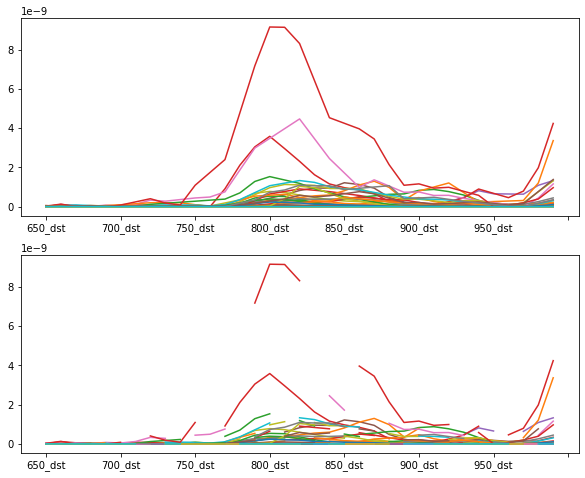

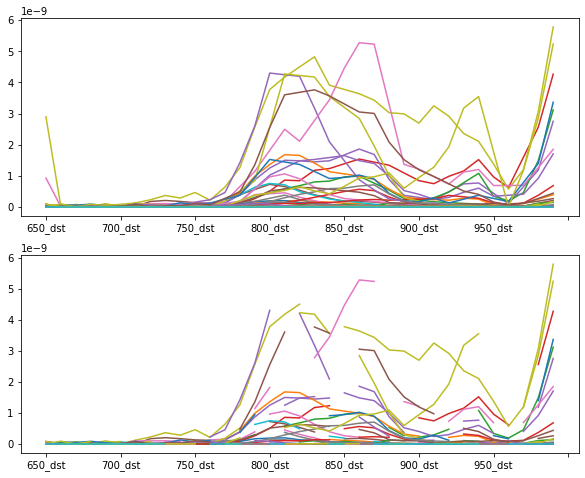

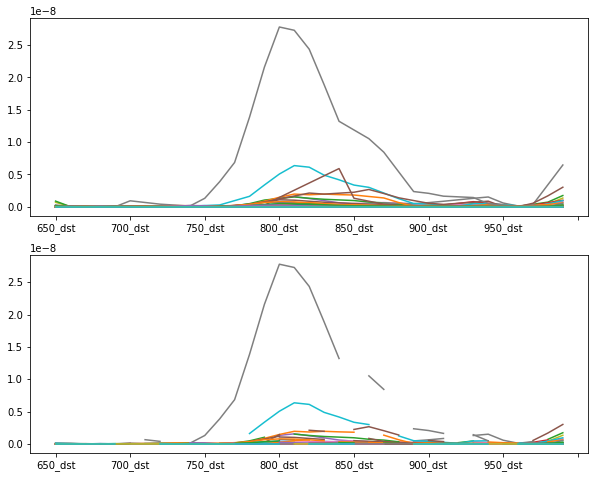

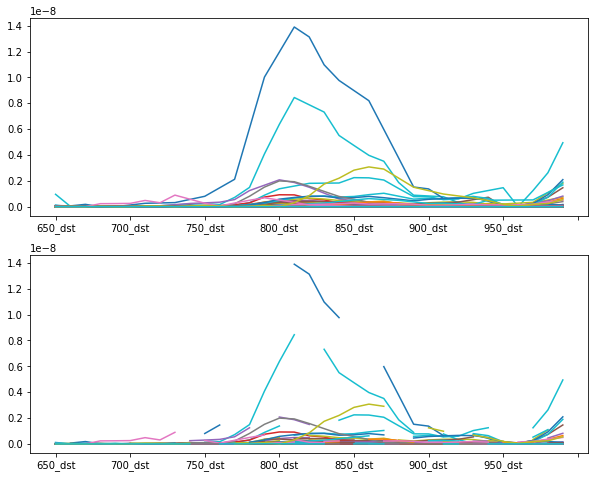

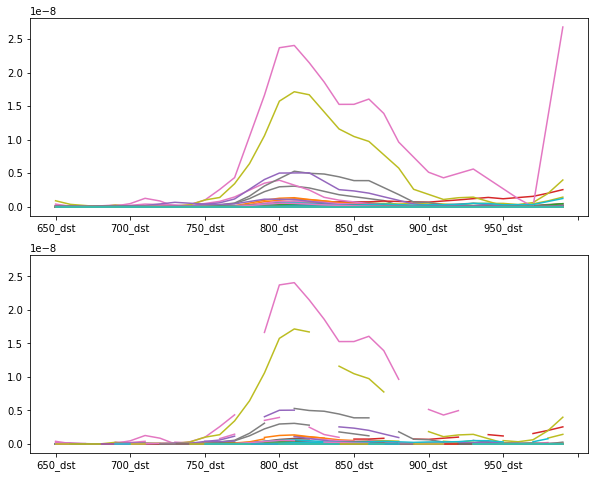

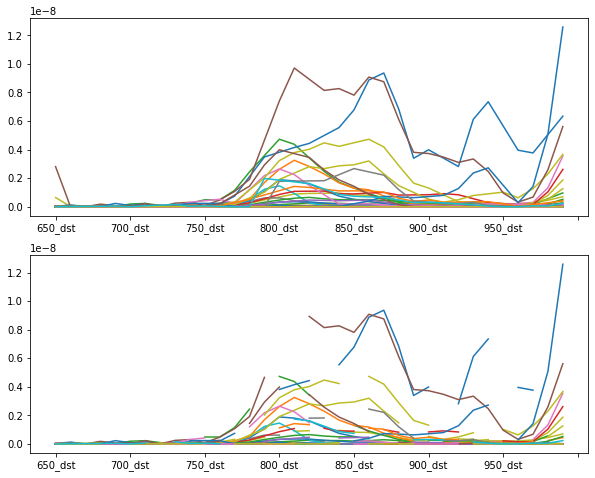

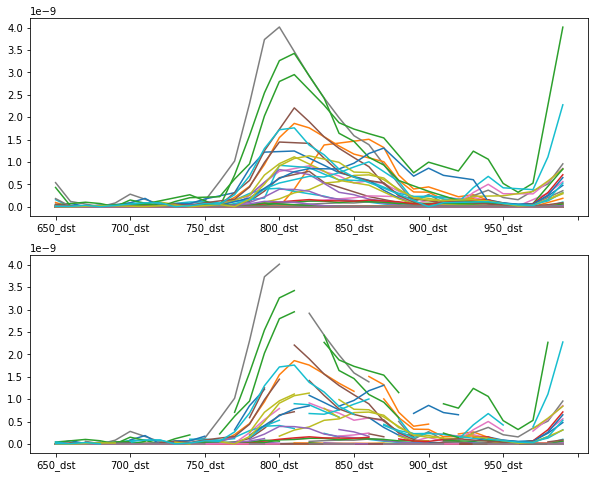

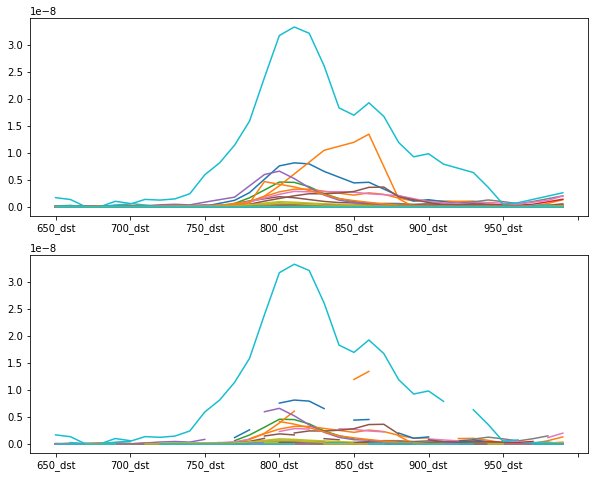

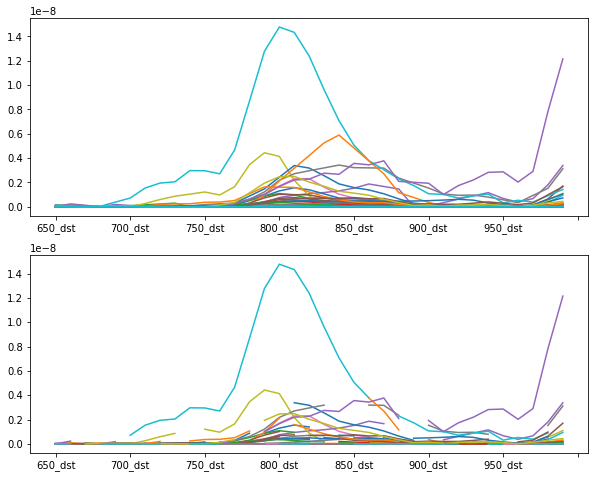

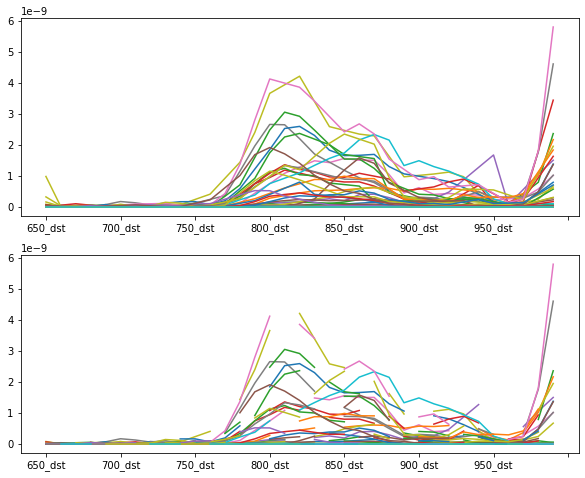

In [0]:
for i in range(10):
    a = 3500 + i*300
    b = a + 100

    fig, axes = plt.subplots(nrows=2)
    train.filter(regex='_dst$').iloc[a:b,:].T.plot(legend=False, figsize=(10,8), ax=axes[0])
    train2 = pd.read_csv(path+'train.csv')
    train2.filter(regex='_dst$').iloc[a:b,:].T.plot(legend=False, figsize=(10,8), ax=axes[1])
    plt.show()

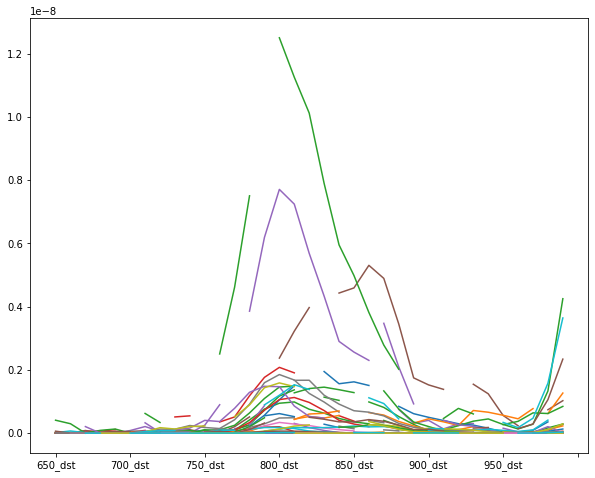

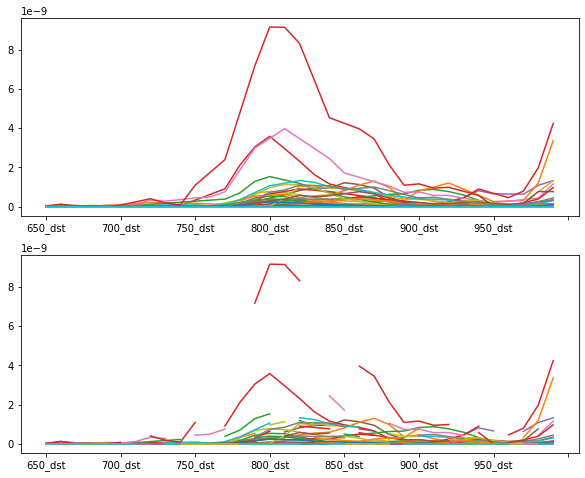

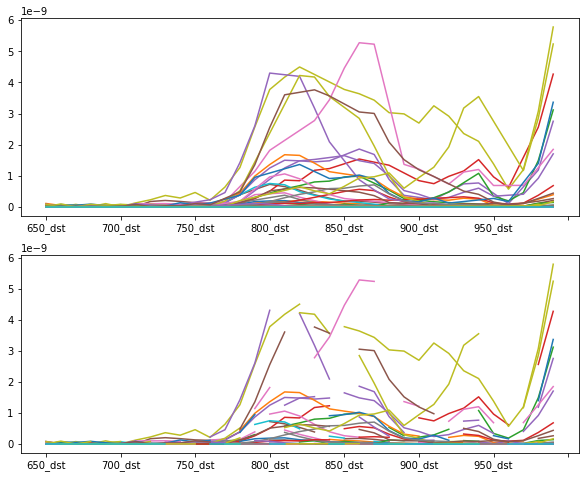

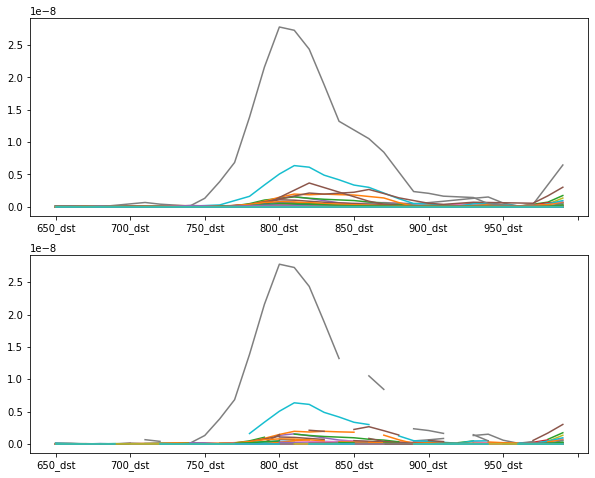

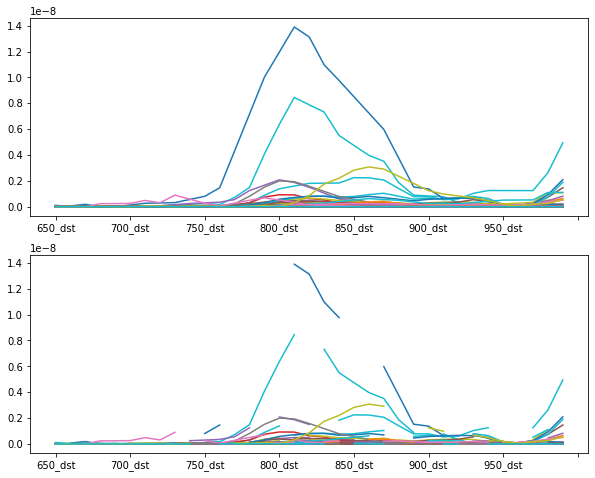

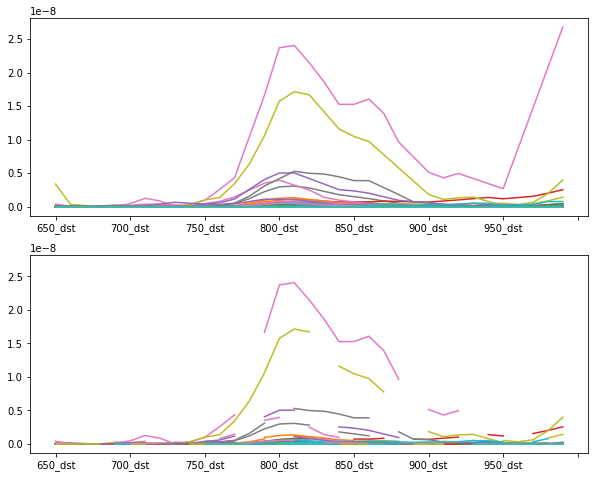

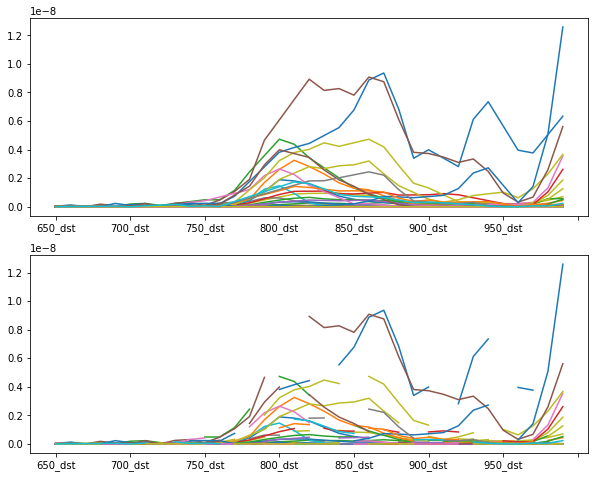

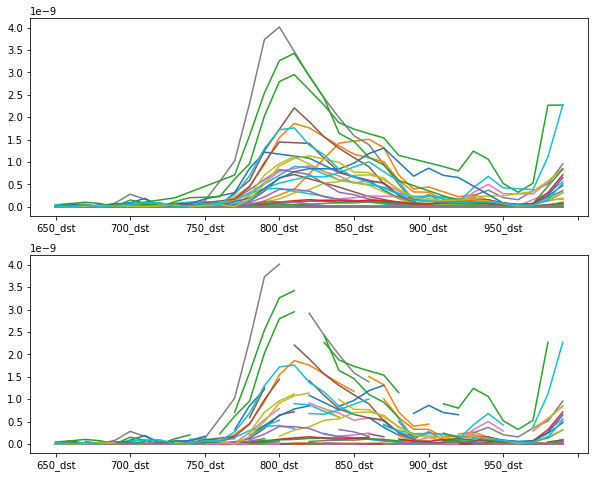

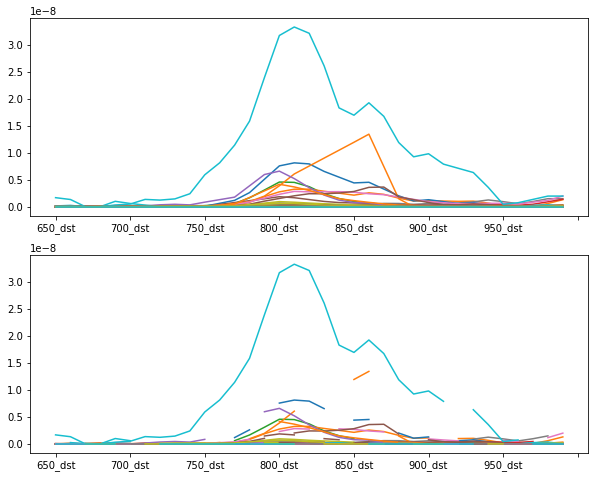

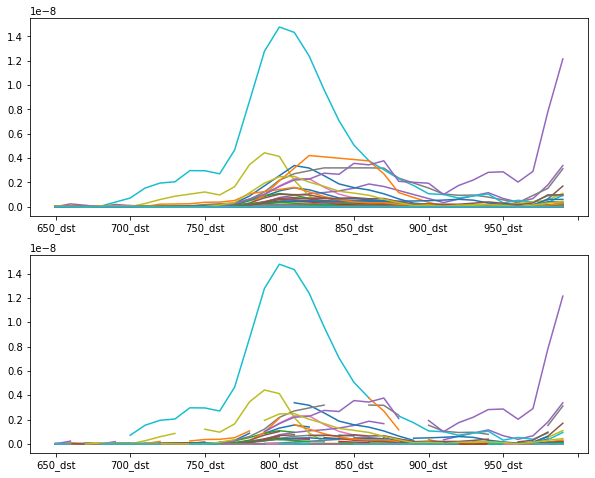

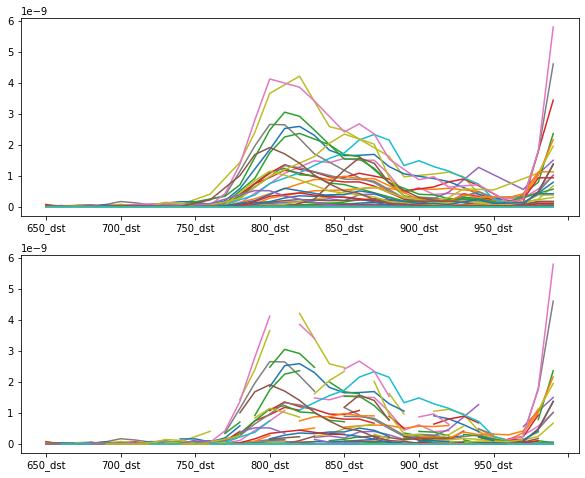

In [0]:
test2 = pd.read_csv(path+'test.csv')
test2.filter(regex='_dst$').iloc[a:b,:].T.plot(legend=False, figsize=(10,8))



for i in range(10):
    a = 3500 + i*300
    b = a + 100

    fig, axes = plt.subplots(nrows=2)
    train.filter(regex='_dst$').iloc[a:b,:].T.plot(legend=False, figsize=(10,8), ax=axes[0])
    test2 = pd.read_csv(path+'train.csv')
    test2.filter(regex='_dst$').iloc[a:b,:].T.plot(legend=False, figsize=(10,8), ax=axes[1])
    plt.show()

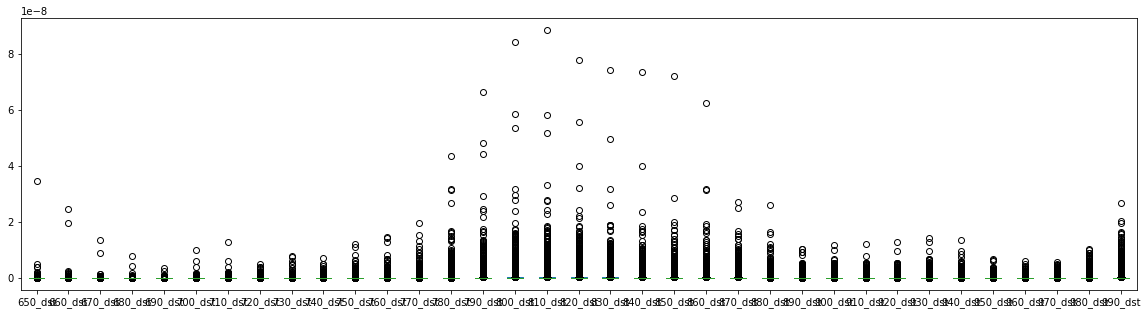

In [0]:
test2.filter(regex='dst').iloc[:,:].plot(legend=False, kind='box', figsize=(20,5))

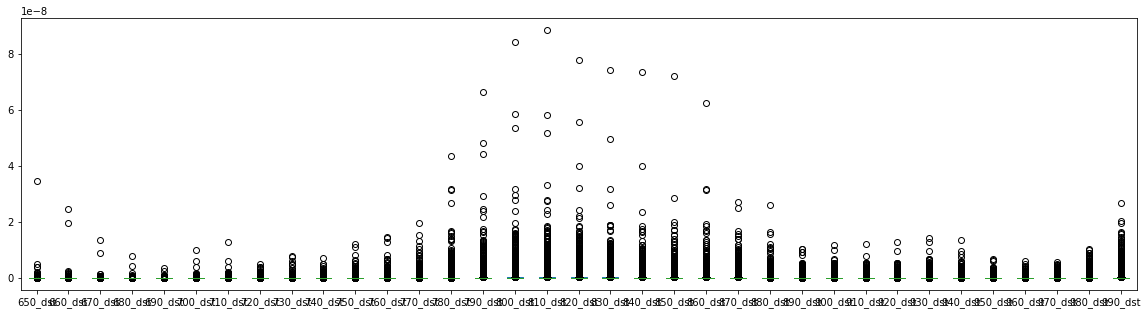

In [0]:
train2.filter(regex='dst').iloc[:,:].plot(legend=False, kind='box', figsize=(20,5))